In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
from dust3r.inference import inference
from dust3r.model import AsymmetricCroCo3DStereo
from dust3r.utils.image import load_images
from dust3r.image_pairs import make_pairs
from dust3r.cloud_opt import global_aligner, GlobalAlignerMode
from dust3r.datasets.freiburgDataset import freiburgDataset 
import tqdm
import matplotlib.pyplot as plt
import numpy as np 


import torchvision.transforms as T
from PIL import Image
import torch


### Quantative Analysis

In [ ]:

def compute_accuracy(pred1, gt1):        
# Compute the L2 loss for depth (between predicted and ground truth depth)
        depth_pred = pred1['pts3d'][..., 2]  # Extract the predicted depth (z-coordinate)
        gt_depthmap = torch.tensor(gt1["depthmap"]).to(depth_pred.device)
        # l1 = self.criterion(depth_pred,gt_depthmap)
        # depth_loss = torch.sqrt(torch.mean((depth_pred - gt_depthmap)**2))

        
        epsilon = 1e-8  # To avoid log(0)
        log_diff = torch.log(depth_pred + epsilon) - torch.log(gt_depthmap + epsilon)
        loss = torch.sqrt(torch.mean(log_diff ** 2) - (torch.mean(log_diff) ** 2))

        # # Compute accuracy-based loss (Threshold-based accuracy)
        threshold = torch.max(depth_pred / gt_depthmap, gt_depthmap / depth_pred)
        acc_1_25 = torch.mean((threshold < 1.25).float())  # Accuracy with threshold 1.25
        acc_1_25_2 = torch.mean((threshold < 1.25**2).float())  # Accuracy with threshold 1.25^2



        # # Track individual losses for debugging or analysis
        details = {
            "RMSE Loss": loss.item(),
            "Accuracy < 1.25": acc_1_25.item(),
            "Accuracy < 1.25^2": acc_1_25_2.item()
        }
        
        return details

def average_metrics(array):
    if not array:
        print("Empty array. No averages to compute.")
        return

    keys = array[0].keys()
    total_rmse = sum(d["RMSE Loss"] for d in array)
    averages = {key: sum(d[key] for d in array) / len(array) for key in keys if key != "RMSE Loss"}
    
    print(f"RMSE Loss: {total_rmse:.4f}")
    for key, value in averages.items():
        print(f"{key}: {value:.4f}")

In [27]:
device = "cuda"
batch_size = 1
schedule = 'cosine'
lr = 0.01
niter = 300


model = AsymmetricCroCo3DStereo.from_pretrained("/home/user/zafara1/dust3r/checkpoints/dust3r_demo_1_RansacV2/checkpoint-best.pth", strict=False).to(device)
# model = AsymmetricCroCo3DStereo.from_pretrained(model_name)
# load_images can take a list of images or a directory
test_dataset =freiburgDataset(ROOT='/home/user/zafara1/DataParam', split='Test', resolution=224, aug_crop=16,method = 'RANSAC')

accuracy_list = []

for i in tqdm.tqdm(range(len(test_dataset)), desc="Processing sequence", unit="img"):
    view11,view21 = test_dataset[i]
    img = view11['img'].to(device)
    images = load_images([img,img], size=224,train = False)
    pairs = make_pairs(images, scene_graph='complete', prefilter=None, symmetrize=True)
    output = inference(pairs,model, None, batch_size=batch_size)

    # at this stage, you have the raw dust3r predictions
    view12, pred1 = output['view1'], output['pred1']
    view22, pred2 = output['view2'], output['pred2']
    pts3d = pred1['pts3d']
    # If shape is [B, H, W, 3], permute to [B, 3, H, W]
    if pts3d.shape[-1] == 3:
        pts3d = pts3d.permute(0, 3, 1, 2)

    # Extract the Z-coordinate (depth)
    depth_pred = pts3d[0, 2, :, :].squeeze()


    img = view11["img"]
    if isinstance(img, torch.Tensor):
        img = img.cpu().detach().numpy()
    depth_gt = view11["depthmap"]
    img = view11["img"][0]

    if depth_pred.max() <= 1.0:
        depth_pred = (depth_pred * 255).astype('uint8')

    accuracy_list.append(compute_accuracy(pred1,view11))
        


... loading model from /home/user/zafara1/dust3r/checkpoints/dust3r_demo_1_RansacV2/checkpoint-best.pth
instantiating : AsymmetricCroCo3DStereo(pos_embed='RoPE100', img_size=(224, 224), head_type='linear', output_mode='pts3d', depth_mode=('exp', -inf, inf), conf_mode=('exp', 1, inf), enc_embed_dim=1024, enc_depth=24, enc_num_heads=16, dec_embed_dim=768, dec_depth=12, dec_num_heads=12, landscape_only=False)
<All keys matched successfully>


Processing sequence:   0%|          | 0/64 [00:00<?, ?img/s]

>> Inference with model on 2 image pairs


Processing sequence:   2%|▏         | 1/64 [00:00<01:01,  1.02img/s]

>> Inference with model on 2 image pairs


Processing sequence:   3%|▎         | 2/64 [00:01<00:38,  1.61img/s]

>> Inference with model on 2 image pairs


Processing sequence:   5%|▍         | 3/64 [00:01<00:30,  1.98img/s]

>> Inference with model on 2 image pairs


Processing sequence:   6%|▋         | 4/64 [00:02<00:26,  2.24img/s]

>> Inference with model on 2 image pairs


Processing sequence:   8%|▊         | 5/64 [00:02<00:24,  2.45img/s]

>> Inference with model on 2 image pairs


Processing sequence:   9%|▉         | 6/64 [00:02<00:22,  2.60img/s]

>> Inference with model on 2 image pairs


Processing sequence:  11%|█         | 7/64 [00:03<00:21,  2.70img/s]

>> Inference with model on 2 image pairs


Processing sequence:  12%|█▎        | 8/64 [00:03<00:20,  2.78img/s]

>> Inference with model on 2 image pairs


Processing sequence:  14%|█▍        | 9/64 [00:03<00:19,  2.83img/s]

>> Inference with model on 2 image pairs


Processing sequence:  16%|█▌        | 10/64 [00:04<00:19,  2.82img/s]

>> Inference with model on 2 image pairs


Processing sequence:  17%|█▋        | 11/64 [00:04<00:18,  2.86img/s]

>> Inference with model on 2 image pairs


Processing sequence:  19%|█▉        | 12/64 [00:04<00:18,  2.88img/s]

>> Inference with model on 2 image pairs


Processing sequence:  20%|██        | 13/64 [00:05<00:17,  2.90img/s]

>> Inference with model on 2 image pairs


Processing sequence:  22%|██▏       | 14/64 [00:05<00:17,  2.92img/s]

>> Inference with model on 2 image pairs


Processing sequence:  23%|██▎       | 15/64 [00:05<00:16,  2.92img/s]

>> Inference with model on 2 image pairs


Processing sequence:  25%|██▌       | 16/64 [00:06<00:16,  2.92img/s]

>> Inference with model on 2 image pairs


Processing sequence:  27%|██▋       | 17/64 [00:06<00:16,  2.92img/s]

>> Inference with model on 2 image pairs


Processing sequence:  28%|██▊       | 18/64 [00:06<00:15,  2.92img/s]

>> Inference with model on 2 image pairs


Processing sequence:  30%|██▉       | 19/64 [00:07<00:15,  2.92img/s]

>> Inference with model on 2 image pairs


Processing sequence:  31%|███▏      | 20/64 [00:07<00:15,  2.93img/s]

>> Inference with model on 2 image pairs


Processing sequence:  33%|███▎      | 21/64 [00:07<00:14,  2.93img/s]

>> Inference with model on 2 image pairs


Processing sequence:  34%|███▍      | 22/64 [00:08<00:14,  2.92img/s]

>> Inference with model on 2 image pairs


Processing sequence:  36%|███▌      | 23/64 [00:08<00:14,  2.92img/s]

>> Inference with model on 2 image pairs


Processing sequence:  38%|███▊      | 24/64 [00:08<00:13,  2.92img/s]

>> Inference with model on 2 image pairs


Processing sequence:  39%|███▉      | 25/64 [00:09<00:13,  2.93img/s]

>> Inference with model on 2 image pairs


Processing sequence:  41%|████      | 26/64 [00:09<00:13,  2.92img/s]

>> Inference with model on 2 image pairs


Processing sequence:  42%|████▏     | 27/64 [00:09<00:12,  2.91img/s]

>> Inference with model on 2 image pairs


Processing sequence:  44%|████▍     | 28/64 [00:10<00:12,  2.90img/s]

>> Inference with model on 2 image pairs


Processing sequence:  45%|████▌     | 29/64 [00:10<00:12,  2.90img/s]

>> Inference with model on 2 image pairs


Processing sequence:  47%|████▋     | 30/64 [00:10<00:11,  2.89img/s]

>> Inference with model on 2 image pairs


Processing sequence:  48%|████▊     | 31/64 [00:11<00:11,  2.90img/s]

>> Inference with model on 2 image pairs


Processing sequence:  50%|█████     | 32/64 [00:11<00:11,  2.90img/s]

>> Inference with model on 2 image pairs


Processing sequence:  52%|█████▏    | 33/64 [00:12<00:10,  2.91img/s]

>> Inference with model on 2 image pairs


Processing sequence:  53%|█████▎    | 34/64 [00:12<00:10,  2.91img/s]

>> Inference with model on 2 image pairs


Processing sequence:  55%|█████▍    | 35/64 [00:12<00:09,  2.92img/s]

>> Inference with model on 2 image pairs


Processing sequence:  56%|█████▋    | 36/64 [00:13<00:09,  2.92img/s]

>> Inference with model on 2 image pairs


Processing sequence:  58%|█████▊    | 37/64 [00:13<00:09,  2.91img/s]

>> Inference with model on 2 image pairs


Processing sequence:  59%|█████▉    | 38/64 [00:13<00:08,  2.91img/s]

>> Inference with model on 2 image pairs


Processing sequence:  61%|██████    | 39/64 [00:14<00:08,  2.90img/s]

>> Inference with model on 2 image pairs


Processing sequence:  62%|██████▎   | 40/64 [00:14<00:08,  2.89img/s]

>> Inference with model on 2 image pairs


Processing sequence:  64%|██████▍   | 41/64 [00:14<00:07,  2.89img/s]

>> Inference with model on 2 image pairs


Processing sequence:  66%|██████▌   | 42/64 [00:15<00:07,  2.90img/s]

>> Inference with model on 2 image pairs


Processing sequence:  67%|██████▋   | 43/64 [00:15<00:07,  2.90img/s]

>> Inference with model on 2 image pairs


Processing sequence:  69%|██████▉   | 44/64 [00:15<00:06,  2.91img/s]

>> Inference with model on 2 image pairs


Processing sequence:  70%|███████   | 45/64 [00:16<00:06,  2.91img/s]

>> Inference with model on 2 image pairs


Processing sequence:  72%|███████▏  | 46/64 [00:16<00:06,  2.90img/s]

>> Inference with model on 2 image pairs


Processing sequence:  73%|███████▎  | 47/64 [00:16<00:05,  2.90img/s]

>> Inference with model on 2 image pairs


Processing sequence:  75%|███████▌  | 48/64 [00:17<00:05,  2.90img/s]

>> Inference with model on 2 image pairs


Processing sequence:  77%|███████▋  | 49/64 [00:17<00:05,  2.90img/s]

>> Inference with model on 2 image pairs


Processing sequence:  78%|███████▊  | 50/64 [00:17<00:04,  2.90img/s]

>> Inference with model on 2 image pairs


Processing sequence:  80%|███████▉  | 51/64 [00:18<00:04,  2.89img/s]

>> Inference with model on 2 image pairs


Processing sequence:  81%|████████▏ | 52/64 [00:18<00:04,  2.88img/s]

>> Inference with model on 2 image pairs


Processing sequence:  83%|████████▎ | 53/64 [00:18<00:03,  2.89img/s]

>> Inference with model on 2 image pairs


Processing sequence:  84%|████████▍ | 54/64 [00:19<00:03,  2.90img/s]

>> Inference with model on 2 image pairs


Processing sequence:  86%|████████▌ | 55/64 [00:19<00:03,  2.91img/s]

>> Inference with model on 2 image pairs


Processing sequence:  88%|████████▊ | 56/64 [00:19<00:02,  2.91img/s]

>> Inference with model on 2 image pairs


Processing sequence:  89%|████████▉ | 57/64 [00:20<00:02,  2.91img/s]

>> Inference with model on 2 image pairs


Processing sequence:  91%|█████████ | 58/64 [00:20<00:02,  2.91img/s]

>> Inference with model on 2 image pairs


Processing sequence:  92%|█████████▏| 59/64 [00:20<00:01,  2.91img/s]

>> Inference with model on 2 image pairs


Processing sequence:  94%|█████████▍| 60/64 [00:21<00:01,  2.91img/s]

>> Inference with model on 2 image pairs


Processing sequence:  95%|█████████▌| 61/64 [00:21<00:01,  2.91img/s]

>> Inference with model on 2 image pairs


Processing sequence:  97%|█████████▋| 62/64 [00:21<00:00,  2.91img/s]

>> Inference with model on 2 image pairs


Processing sequence:  98%|█████████▊| 63/64 [00:22<00:00,  2.91img/s]

>> Inference with model on 2 image pairs


Processing sequence: 100%|██████████| 64/64 [00:22<00:00,  2.82img/s]


In [31]:
average_metrics(accuracy_list)
    

RMSE Loss: 10.2426
Accuracy < 1.25: 0.2403
Accuracy < 1.25^2: 0.6069


### Qualitative Analysis

#### Freiburg Thermal Dataset

... loading model from /home/user/zafara1/dust3r/checkpoints/dust3r_demo_1_RansacV2/checkpoint-best.pth
instantiating : AsymmetricCroCo3DStereo(pos_embed='RoPE100', img_size=(224, 224), head_type='linear', output_mode='pts3d', depth_mode=('exp', -inf, inf), conf_mode=('exp', 1, inf), enc_embed_dim=1024, enc_depth=24, enc_num_heads=16, dec_embed_dim=768, dec_depth=12, dec_num_heads=12, landscape_only=False)
<All keys matched successfully>


Processing sequence:   0%|          | 0/5 [00:00<?, ?img/s]

>> Inference with model on 2 image pairs


100%|██████████| 2/2 [00:01<00:00,  1.16it/s]


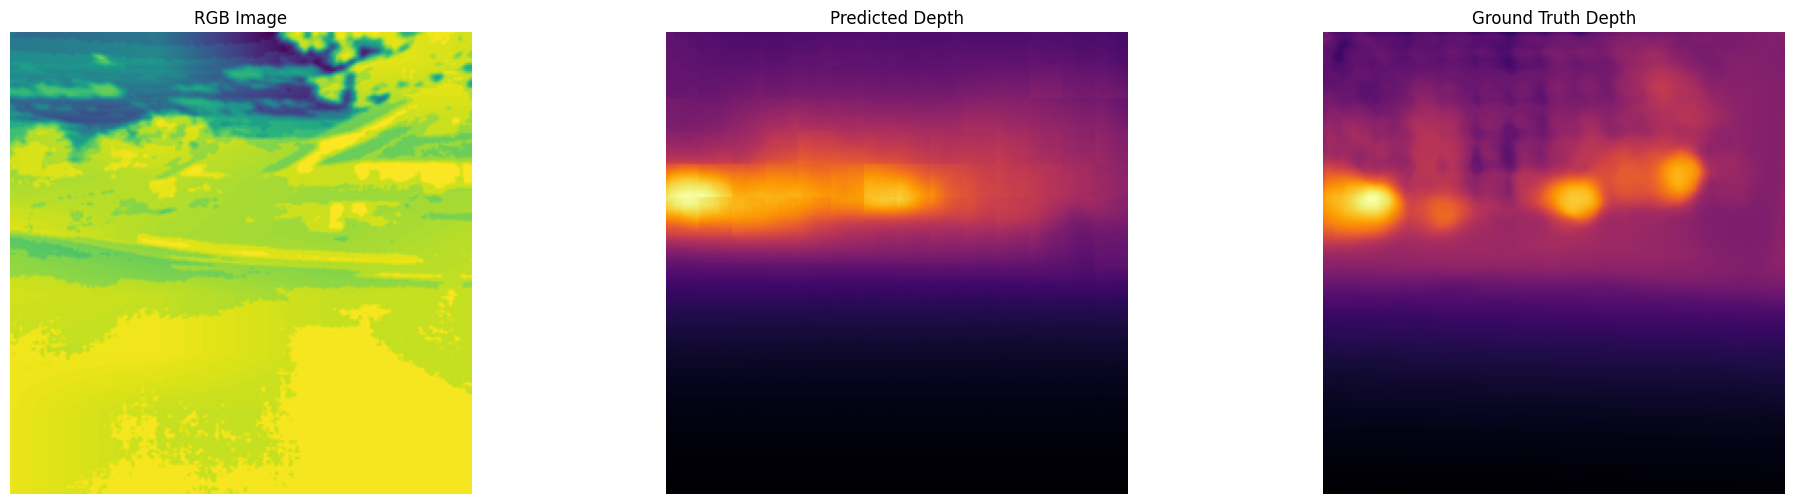

Processing sequence:  20%|██        | 1/5 [00:02<00:08,  2.11s/img]

>> Inference with model on 2 image pairs


100%|██████████| 2/2 [00:01<00:00,  1.16it/s]


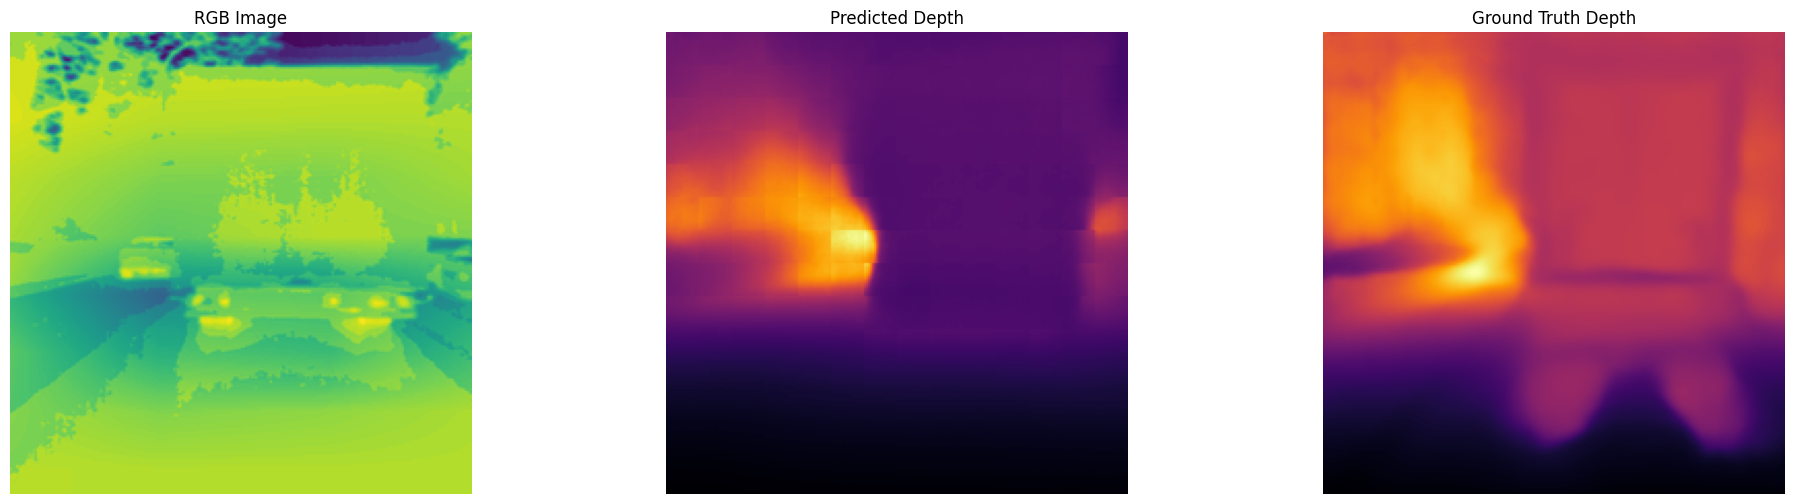

Processing sequence:  40%|████      | 2/5 [00:04<00:06,  2.11s/img]

>> Inference with model on 2 image pairs


100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


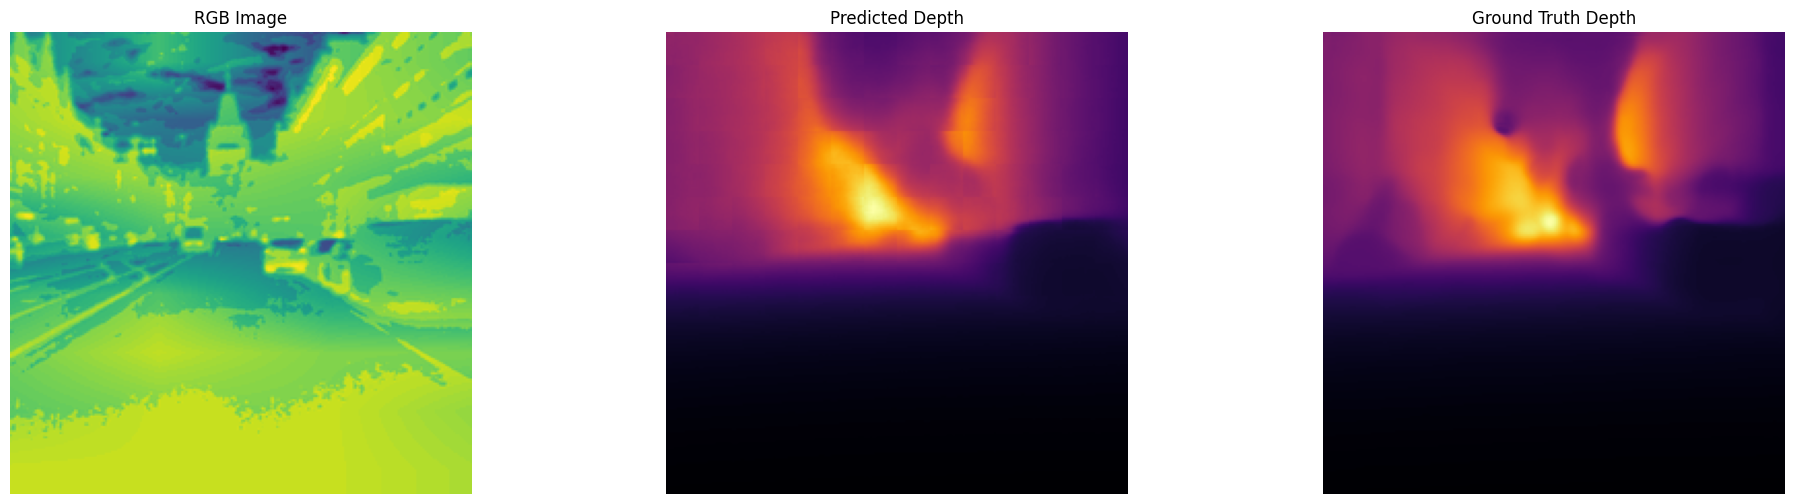

Processing sequence:  60%|██████    | 3/5 [00:06<00:04,  2.13s/img]

>> Inference with model on 2 image pairs


100%|██████████| 2/2 [00:01<00:00,  1.16it/s]


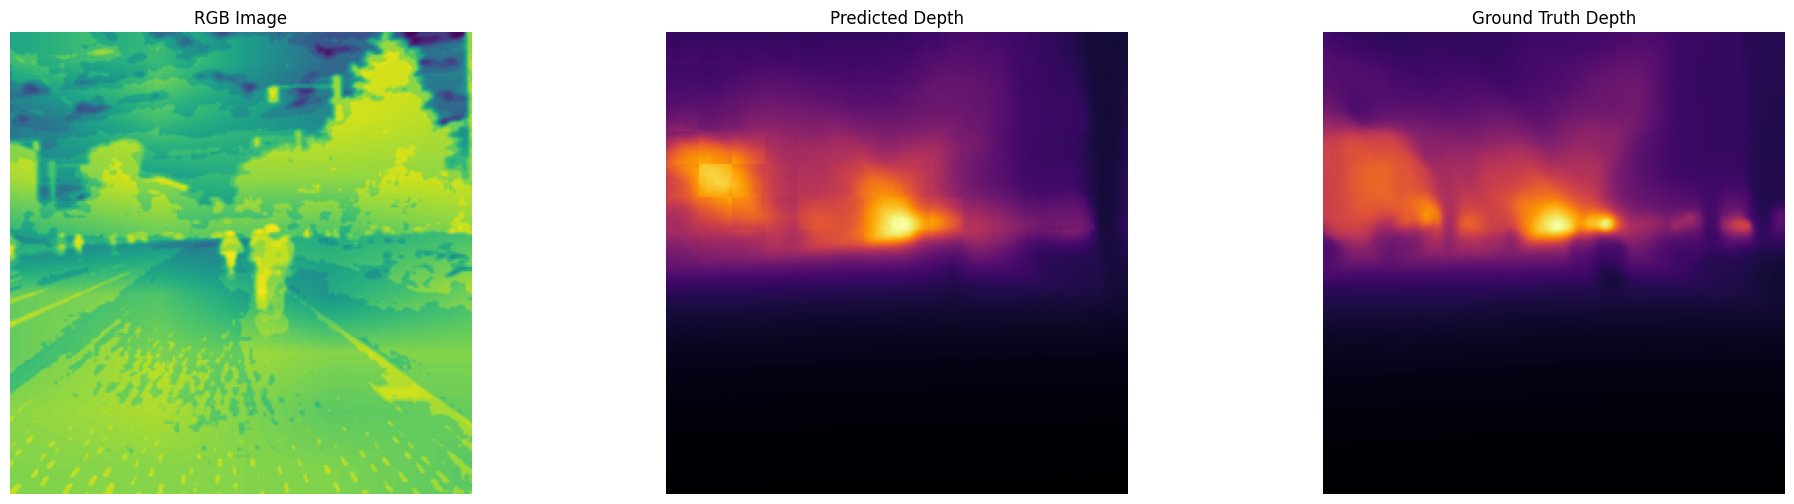

Processing sequence:  80%|████████  | 4/5 [00:08<00:02,  2.14s/img]

>> Inference with model on 2 image pairs


100%|██████████| 2/2 [00:01<00:00,  1.14it/s]


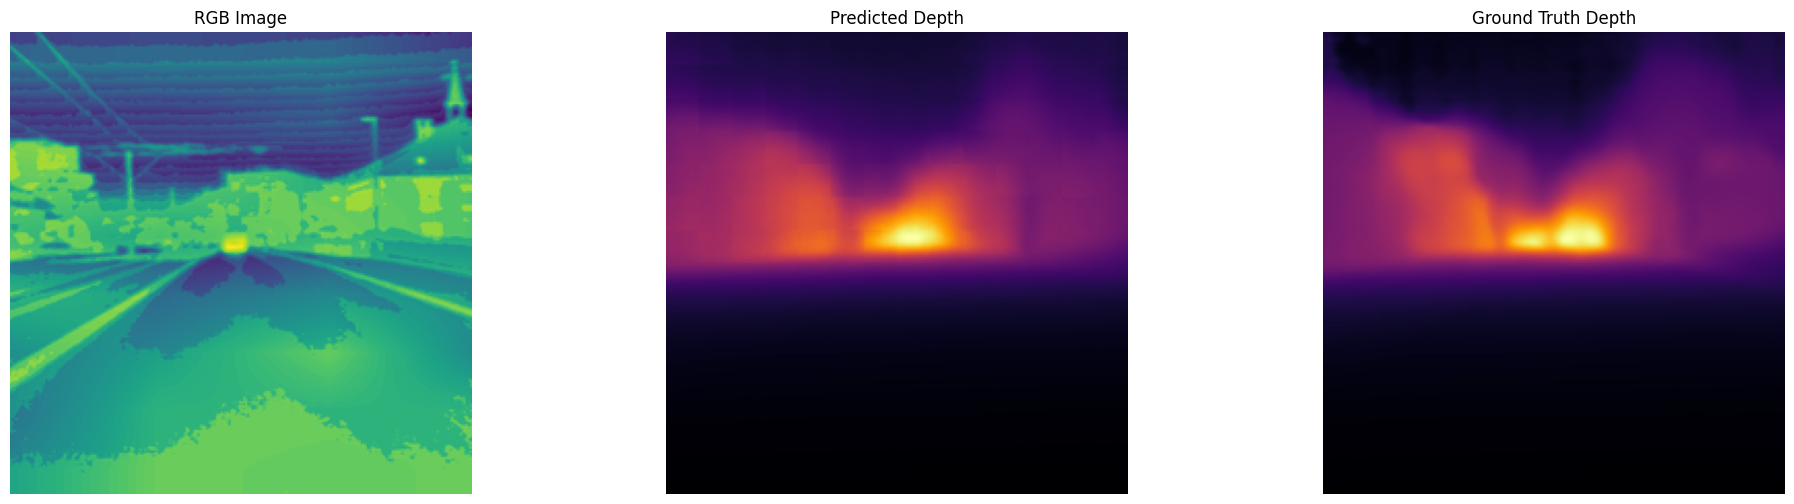

Processing sequence: 100%|██████████| 5/5 [00:10<00:00,  2.13s/img]


In [ ]:


device = 'cuda'
batch_size = 1
schedule = 'cosine'
lr = 0.01
niter = 300

# model_name = "naver/DUSt3R_ViTLarge_BaseDecoder_512_dpt"
# you can put the path to a local checkpoint in model_name if needed
model = AsymmetricCroCo3DStereo.from_pretrained("/home/user/zafara1/dust3r/checkpoints/dust3r_demo_1_RansacV2/checkpoint-best.pth", strict=False)
# model = AsymmetricCroCo3DStereo.from_pretrained(model_name)
# load_images can take a list of images or a directory
test_dataset =freiburgDataset(ROOT='/home/user/zafara1/DataParam', split='Test', resolution=224, aug_crop=16,method = 'RANSAC')

for i in tqdm.tqdm(range(5), desc="Processing sequence", unit="img"):
    view11,view21 = test_dataset[i]
    img = view11['img']
    images = load_images([img,img], size=224,train = False)
    pairs = make_pairs(images, scene_graph='complete', prefilter=None, symmetrize=True)
    output = inference(pairs,model, None, batch_size=batch_size)

    # at this stage, you have the raw dust3r predictions
    view12, pred1 = output['view1'], output['pred1']
    view22, pred2 = output['view2'], output['pred2']
    pts3d = pred1['pts3d']
    # If shape is [B, H, W, 3], permute to [B, 3, H, W]
    if pts3d.shape[-1] == 3:
        pts3d = pts3d.permute(0, 3, 1, 2)

    # Extract the Z-coordinate (depth)
    depth_pred = pts3d[0, 2, :, :].squeeze()


    img = view11["img"]
    if isinstance(img, torch.Tensor):
        img = img.cpu().detach().numpy()
    depth_gt = view11["depthmap"]
    img = view11["img"][0]

    if depth_pred.max() <= 1.0:
        depth_pred = (depth_pred * 255).astype('uint8')
    # Create a subplot with 1 row and 3 columns
    fig, ax = plt.subplots(1, 3, figsize=(24, 6))

    # Plot the RGB image (img)
    ax[0].imshow(img)  # For RGB, no cmap needed
    ax[0].axis('off')  # Hide axes for a cleaner view
    ax[0].set_title('RGB Image')

    # Plot the predicted depth map (depth_pred) with colormap 'turbo'
    ax[1].imshow(depth_pred, cmap='inferno') 
    ax[1].axis('off')  # Hide axes
    ax[1].set_title('Predicted Depth')

    # Plot the ground truth depth map (depth_gt) 
    ax[2].imshow(depth_gt, cmap='inferno')  
    ax[2].axis('off')  # Hide axes
    ax[2].set_title('Ground Truth Depth')

    # Show the images
    plt.show()
        


#### AIS Dataset

Processing sequence:   0%|          | 0/4 [00:00<?, ?img/s]

>> Inference with model on 2 image pairs


100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


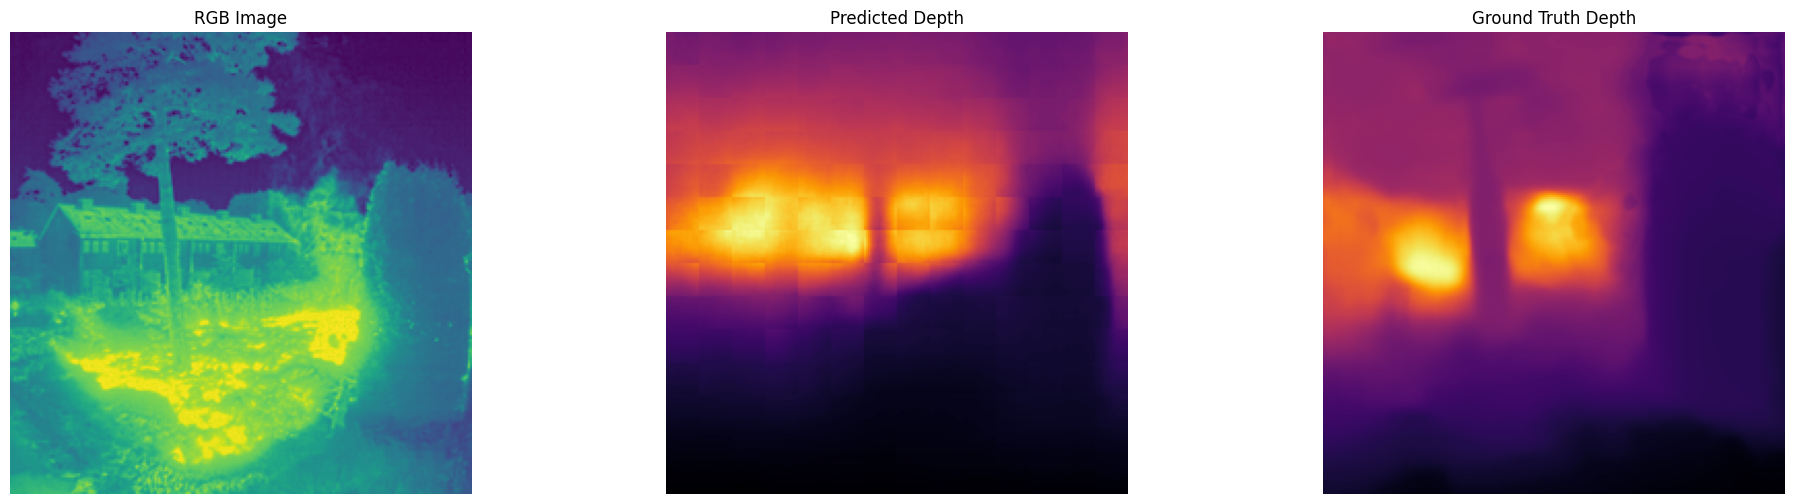

Processing sequence:  25%|██▌       | 1/4 [00:02<00:06,  2.06s/img]

>> Inference with model on 2 image pairs


100%|██████████| 2/2 [00:01<00:00,  1.14it/s]


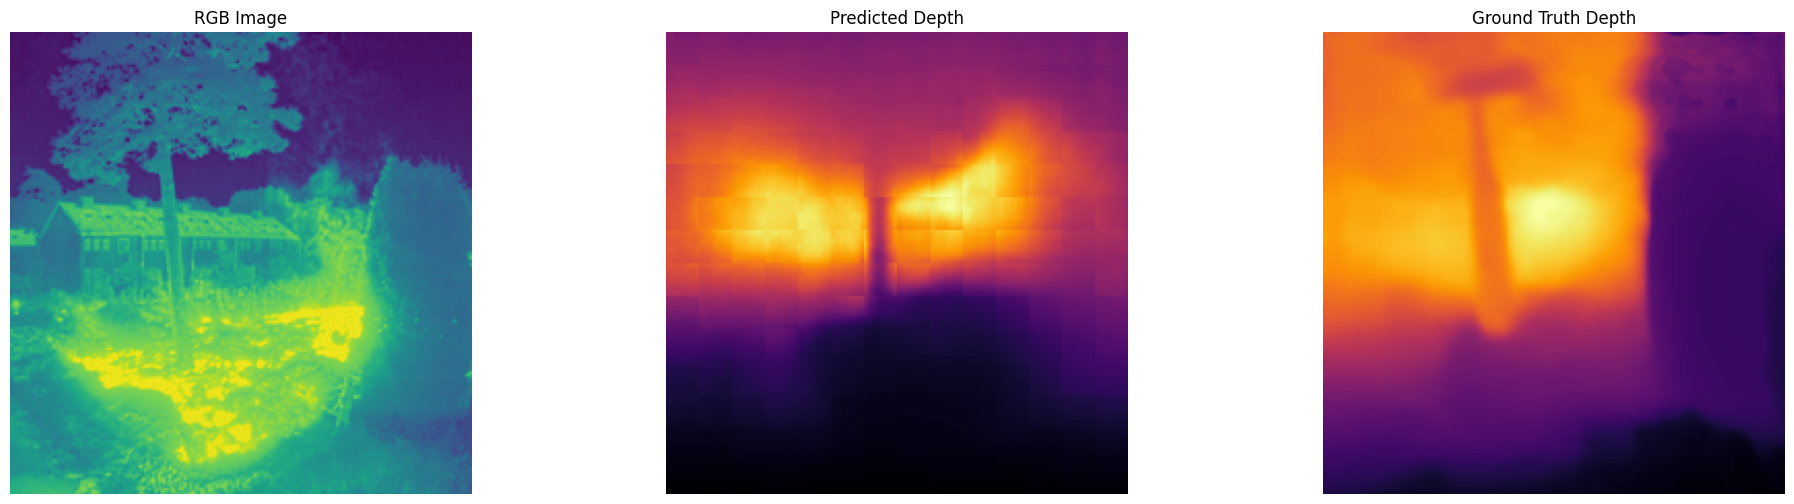

Processing sequence:  50%|█████     | 2/4 [00:04<00:04,  2.07s/img]

>> Inference with model on 2 image pairs


100%|██████████| 2/2 [00:01<00:00,  1.14it/s]


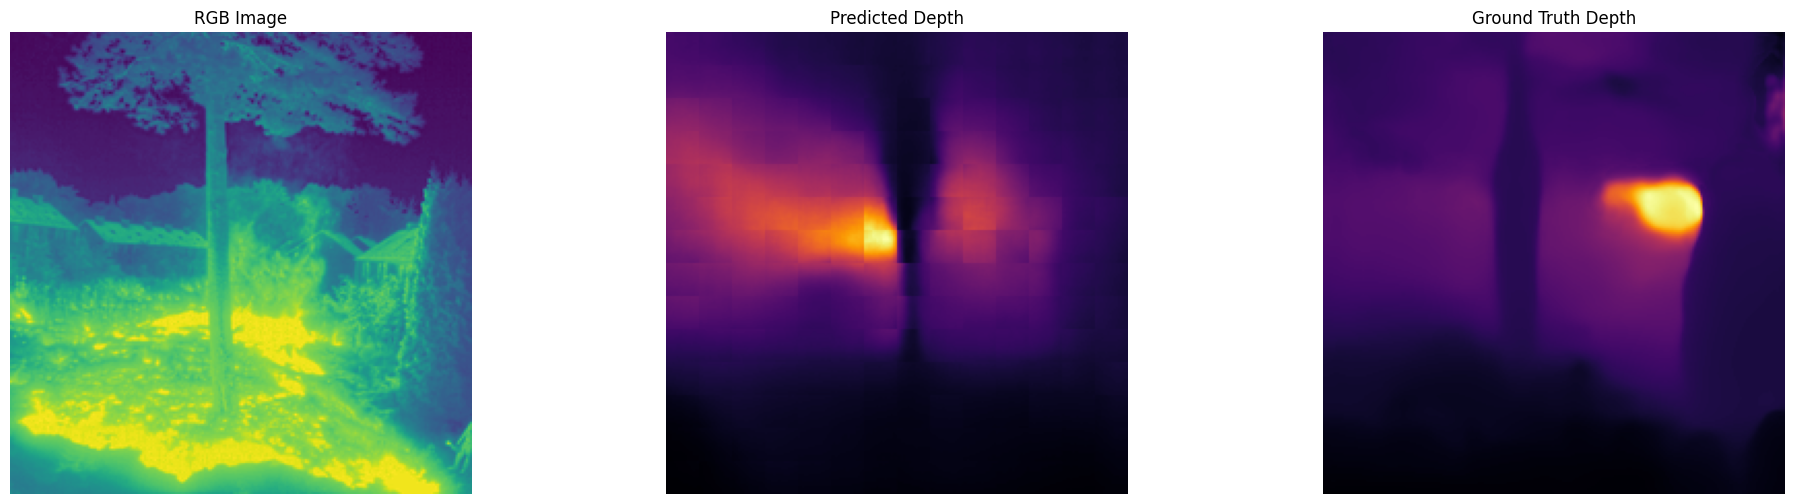

Processing sequence:  75%|███████▌  | 3/4 [00:06<00:02,  2.09s/img]

>> Inference with model on 2 image pairs


100%|██████████| 2/2 [00:01<00:00,  1.14it/s]


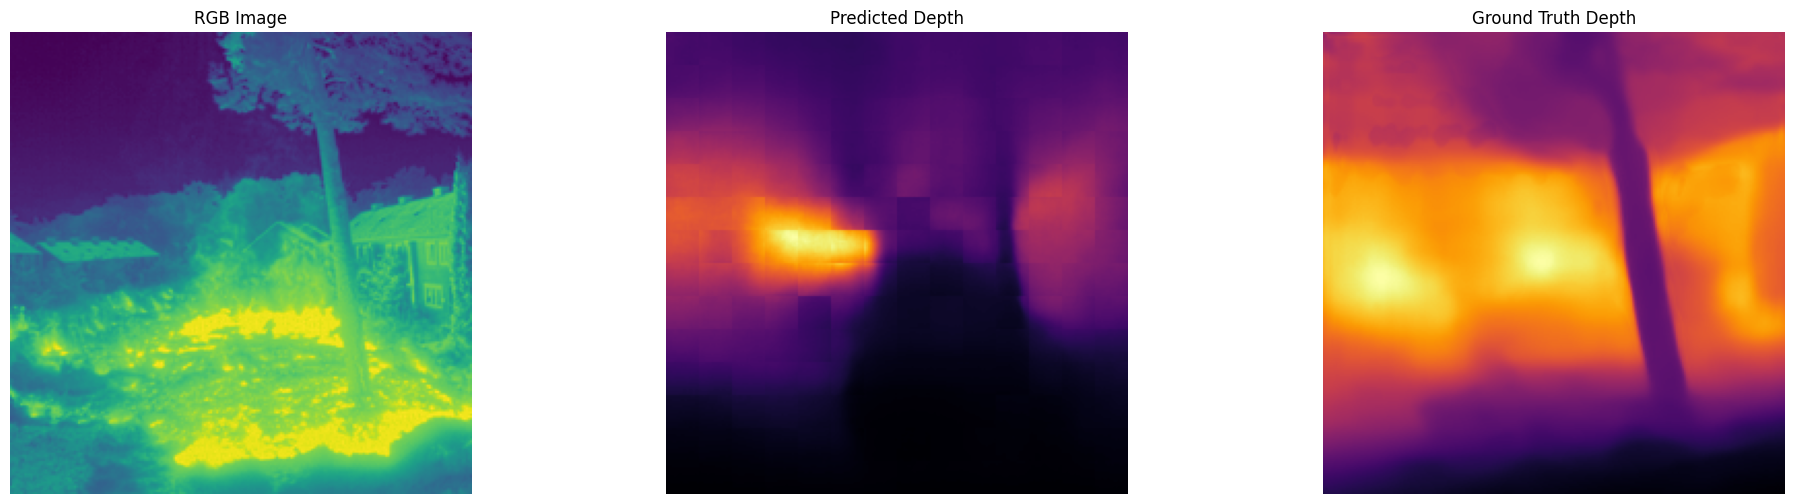

Processing sequence: 100%|██████████| 4/4 [00:08<00:00,  2.11s/img]


In [ ]:
from dust3r.datasets.AISdataset import AISDataset

ais_data = AISDataset(ROOT="/home/user/zafara1/ThermalImages/test_data",method="Procrustes", split = "Train",resolution=224, aug_crop=16)

for i in tqdm.tqdm(range(0,20,5), desc="Processing sequence", unit="img"):
    view11,view21 = ais_data[i]
    img = view11['img']
    images = load_images([img,img], size=224,train = False)
    pairs = make_pairs(images, scene_graph='complete', prefilter=None, symmetrize=True)
    output = inference(pairs,model, None, batch_size=batch_size)

    # at this stage, you have the raw dust3r predictions
    view12, pred1 = output['view1'], output['pred1']
    view22, pred2 = output['view2'], output['pred2']
    pts3d = pred1['pts3d']
    # If shape is [B, H, W, 3], permute to [B, 3, H, W]
    if pts3d.shape[-1] == 3:
        pts3d = pts3d.permute(0, 3, 1, 2)

    # Extract the Z-coordinate (depth)
    depth_pred = pts3d[0, 2, :, :].squeeze()


    img = view11["img"]
    if isinstance(img, torch.Tensor):
        img = img.cpu().detach().numpy()
    depth_gt = view11["depthmap"]
    img = view11["img"][0]

    if depth_pred.max() <= 1.0:
        depth_pred = (depth_pred * 255).astype('uint8')
    # Create a subplot with 1 row and 3 columns
    fig, ax = plt.subplots(1, 3, figsize=(24, 6))

    # Plot the RGB image (img)
    ax[0].imshow(img)  # For RGB, no cmap needed
    ax[0].axis('off')  # Hide axes for a cleaner view
    ax[0].set_title('RGB Image')

    # Plot the predicted depth map (depth_pred) with colormap 'turbo'
    ax[1].imshow(depth_pred, cmap='inferno') 
    ax[1].axis('off')  # Hide axes
    ax[1].set_title('Predicted Depth')

    # Plot the ground truth depth map (depth_gt) 
    ax[2].imshow(depth_gt, cmap='inferno')  
    ax[2].axis('off')  # Hide axes
    ax[2].set_title('Ground Truth Depth')

    # Show the images
    plt.show()
    
